In [209]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, cross_validation
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
from sklearn.metrics import roc_curve, auc
import sklearn.tree as tree
import seaborn as sns
import graphviz 
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE, ADASYN
from statsmodels.discrete.discrete_model import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import StandardScaler

In [71]:
# fb_df = pd.read_csv('csv/fb_tweets_stock.csv', index_col = 0)
# netflix_df = pd.read_csv('csv/netflix_tweets_stock.csv', index_col = 0)
# apple_df = pd.read_csv('csv/apple_tweets_stock.csv', index_col = 0)

In [81]:
# fb_df['company'] = np.full((len(fb_df),1), "Facebook")
# netflix_df['company'] = np.full((len(netflix_df),1), "Netflix")
# apple_df['company'] = np.full((len(apple_df),1), "Apple")

In [102]:
# # rearranging the columns
# fb_df = fb_df[list(apple_df.columns.values)]
# missing_cols_netflix = [column for column in fb_df if column not in list(netflix_df.columns)]
# for col in missing_cols_netflix:
#     netflix_df[col] = np.nan
# # rearranging the columns
# netflix_df = netflix_df[list(apple_df.columns.values)]
# df = pd.concat([fb_df, netflix_df, apple_df], axis = 0)
# df.to_csv('fb_netflix_apple.csv')

In [129]:
df = pd.read_csv('csv/fb_netflix_apple.csv', index_col = 0)

In [137]:
df['company'] = df['company'].map({'Facebook': 1, 'Netflix': 2, 'Apple': 3})

In [214]:
df_fb = df[df['company'] ==1]
df_nf = df[df['company'] ==2]
df_ap = df[df['company'] ==3]

In [158]:
target = df['up_down']
X = df.loc[:, df.columns != 'up_down']
X = X.drop(['day', 'increase_decrease','movement(%)' ], axis = 1)

In [159]:
# normalize the data
def normalize(column):
    minimum = X[column].min()
    maximum = X[column].max()
    diff = maximum - minimum
    norm = (X[column] - minimum) / diff
    return norm

In [160]:
for column in list(X.columns):
    X[column] = normalize(column)

In [161]:
target = target.fillna(0)
X = X.fillna(0)

In [162]:
# tuning the weight using SMOTE
print(target.value_counts())
X_resampled, y_resampled = SMOTE().fit_sample(X, target) 
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

1    83
0    73
Name: up_down, dtype: int64
1    83
0    83
dtype: int64


In [198]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm,  cmap) #Create the basic matrix.
    #Add title and Axis Labels
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    class_names = set(classes) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2. #Used for text coloring below
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    plt.show()

train set accuracy: 0.782258064516129


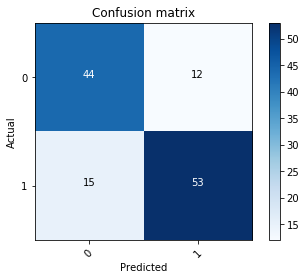

test set accuracy: 0.6666666666666666


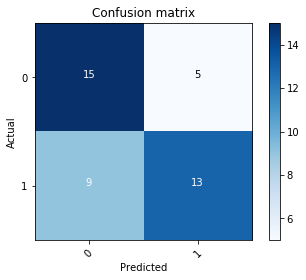

             precision    recall  f1-score   support

          0       0.62      0.75      0.68        20
          1       0.72      0.59      0.65        22

avg / total       0.68      0.67      0.67        42

0.5963855421686747
             precision    recall  f1-score   support

          0       0.65      0.59      0.62        92
          1       0.54      0.61      0.57        74

avg / total       0.60      0.60      0.60       166



In [199]:
def test_set(X, Y) :
    data_train, data_test, target_train, target_test = train_test_split(X, Y)
    logreg = LogisticRegression()
    logreg.fit(data_train, target_train)
    predict_train = logreg.predict(data_train)
    predict_test = logreg.predict(data_test)
    cnf_matrix_train = confusion_matrix(predict_train, target_train)
    cnf_matrix_test = confusion_matrix(predict_test, target_test)
    print('train set accuracy: ' + str(metrics.accuracy_score(predict_train, target_train)))
    plot_confusion_matrix(cnf_matrix_train, classes = set(y_resampled))
    print('test set accuracy: ' + str(metrics.accuracy_score(predict_test, target_test)))
    plot_confusion_matrix(cnf_matrix_test, classes = set(y_resampled))
    print(metrics.classification_report(predict_test, target_test))
    
test_set(X_resampled, y_resampled)

## cross validation
def k_fold(X, Y, cv = 3):
    predicted = cross_validation.cross_val_predict(LogisticRegression(), X, Y, cv=cv)
    print(metrics.accuracy_score(predicted.reshape((predicted.shape[0],1)), np.array(Y).reshape((Y.shape[0],1))))
    print(metrics.classification_report(predicted.reshape((predicted.shape[0],1)), np.array(Y).reshape((Y.shape[0],1))))

k_fold(X_resampled, y_resampled, cv = 10)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for l1: 0.5530864197530864
LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for l2: 0.6518518518518519


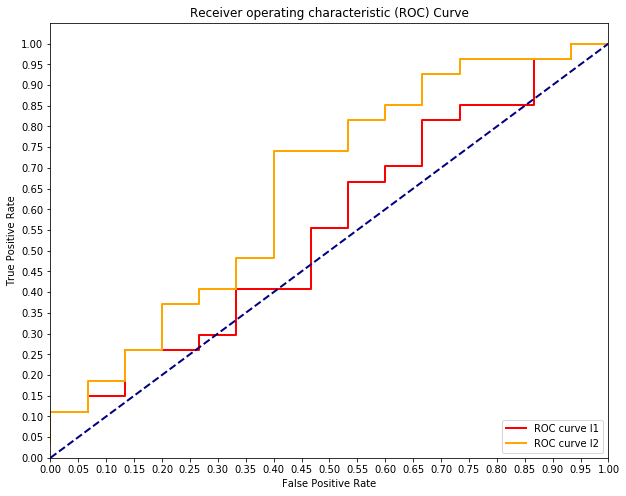

In [164]:
# LASSO Ridge
penalties = ['l1', 'l2']
colors = ['r', 'orange']

plt.figure(figsize=(10,8))

data_train, data_test, target_train, target_test = train_test_split(X_resampled, y_resampled)

for n, pen in enumerate(penalties):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = 1e12, penalty=pen) #Starter code
    model_log = logreg.fit(data_train, target_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(data_test)

    y_score = logreg.fit(data_train, target_train).decision_function(data_test)

    fpr, tpr, thresholds = roc_curve(target_test, y_score)
    
    print('AUC for {}: {}'.format(str(pen), auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(pen))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [337]:
X.head()

,1. open,2. high,3. low,4. close,5. volume,MACD_Hist,MACD,MACD_Signal,SlowK,SlowD,RSI,ADX,CCI,Aroon Up,Aroon Down,Real Middle Band,Real Upper Band,Real Lower Band,Chaikin A/D,OBV,sentiment_avg_30,"coun_neg, 30","coun_neu, 30","coun_pos, 30",sentiment_avg_60,"coun_neg, 60","coun_neu, 60","coun_pos, 60",sentiment_avg_120,"coun_neg, 120","coun_neu, 120","coun_pos, 120",sentiment_night_before_avg,"count_neg, night_before","count_neu, night_before","count_pos, night_before",sentiment_morning_avg,"count_neg, morning","count_neu, morning","count_pos, morning",day compound avg,day positive avg,day negative avg,day neutral avg,two day neutral avg,two day positive avg,two day negative avg,two day compound avg,two day wired compound avg,two day nbc-news compound avg,two day abc-news compound avg,two day reuters compound avg,two day business-insider compound avg,two day the-new-york-times compound avg,two day techcrunch compound avg,two day wired neg avg,two day nbc-news neg avg,two day abc-news neg avg,two day reuters neg avg,two day business-insider neg avg,two day the-new-york-times neg avg,two day techcrunch neg avg,two day wired pos avg,two day nbc-news pos avg,two day abc-news pos avg,two day reuters pos avg,two day business-insider pos avg,two day the-new-york-times pos avg,two day techcrunch pos avg,two day wired neu avg,two day nbc-news neu avg,two day abc-news neu avg,two day reuters neu avg,two day business-insider neu avg,two day the-new-york-times neu avg,two day techcrunch neu avg,one day wired compound avg,one day nbc-news compound avg,one day abc-news compound avg,one day reuters compound avg,one day business-insider compound avg,one day the-new-york-times compound avg,one day techcrunch compound avg,one day wired neg avg,one day nbc-news neg avg,one day abc-news neg avg,one day reuters neg avg,one day business-insider neg avg,one day the-new-york-times neg avg,one day techcrunch neg avg,one day wired pos avg,one day nbc-news pos avg,one day abc-news pos avg,one day reuters pos avg,one day business-insider pos avg,one day the-new-york-times pos avg,one day techcrunch pos avg,one day wired neu avg,one day nbc-news neu avg,one day abc-news neu avg,one day reuters neu avg,one day business-insider neu avg,one day the-new-york-times neu avg,one day techcrunch neu avg,company
2018-08-24 09:30:00,0.002081,0.000848,0.000000,0.000000,0.494640,0.365460,0.053089,0.065069,0.019075,0.000000,0.255916,0.256371,0.420561,0.00,0.75,0.000000,0.000049,0.001075,0.000000,0.052068,0.441811,0.589912,0.662963,0.592199,0.405928,0.739313,0.719026,0.647400,0.301634,0.739110,0.703598,0.746024,0.0,1.0,0.838499,0.374867,0.093509,0.456,0.607273,0.461268,0.008008,0.246353,0.600712,0.662124,0.75,0.094015,0.523156,0.493934,0.998326,0.362483,0.350343,0.659695,0.51325,0.561964,0.866834,0.384328,0.0,0.477876,0.344286,0.518519,0.692941,0.465517,0.075472,0.0,0.010577,1.0,0.29304,0.25814,0.583333,0.806748,1.0,0.793333,0.53207,0.617625,0.714035,0.173684,0.778314,0.362483,0.449221,0.745921,0.720764,0.0,0.929916,0.440299,0.0,0.398968,0.277571,0.342896,0.870504,0.253448,0.0,0.0,0.182489,1.0,0.179176,0.234568,0.547283,0.832822,1.0,0.733333,0.620845,0.838401,0.111111,0.546124,0.0
2018-08-24 10:00:00,0.000000,0.000467,0.001366,0.004167,0.259424,0.380890,0.055957,0.060877,0.316541,0.092377,0.612774,0.155960,0.833740,0.00,0.50,0.000164,0.000684,0.000743,0.011009,0.059841,0.600101,0.289474,0.488889,0.297872,0.405928,0.739313,0.719026,0.647400,0.301634,0.739110,0.703598,0.746024,0.0,1.0,0.838499,0.374867,0.093509,0.456,0.607273,0.461268,0.008008,0.246353,0.600712,0.662124,0.75,0.094015,0.523156,0.493934,0.998326,0.362483,0.350343,0.659695,0.51325,0.561964,0.866834,0.384328,0.0,0.477876,0.344286,0.518519,0.692941,0.465517,0.075472,0.0,0.010577,1.0,0.29304,0.25814,0.583333,0.806748,1.0,0.793333,0.53207,0.617625,0.714035,0.173684,0.778314,0.362483,0.449221,0.745921,0.720764,0.0,0.929916,0.440299,0.0,0.398968,0.277571,0.342896,0.870504,0.253448,0.0,0.0,0.182489,1.0,0.179176,0.2

IndexError: Inconsistent shape between the condition and the input (got (11, 1) and (11,))

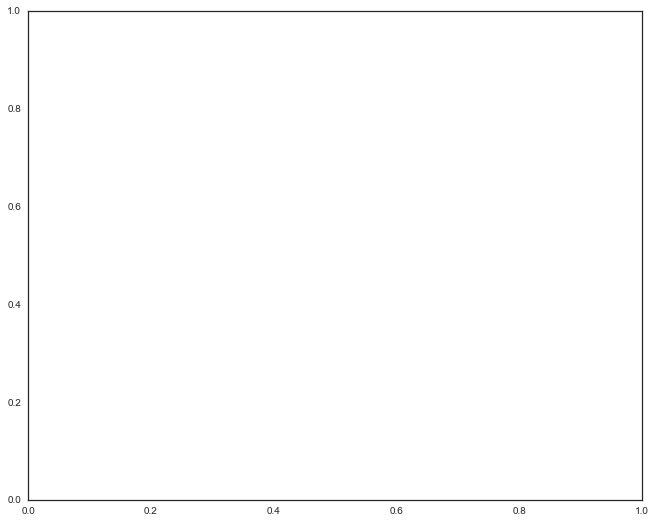

In [350]:
def correlation_heatmap(df, title = 'heatmap'):
    sns.set(style="white")
    # Compute the correlation matrix
    corr = []
    for column in list(df.columns):
        correlation = df['up_down'].corr(df[column])
        corr.append(correlation)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.array(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    ax = plt.axes()
    sns.heatmap(corr)
#                 mask=mask, cmap=cmap, vmax=.3, center=0,
#                 square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
    ax.set_title(title)
    plt.show()
    
twitter_heabtmap = pd.concat([X_tweets_new, df['up_down']], axis =1)
correlation_heatmap(twitter_heabtmap, title = 'heatmap')

X_news = X.loc[:, 'day compound avg':]
X_news = X_news.drop(['company'], axis = 1)
news_heabtmap = pd.concat([X_news, df['up_down']], axis =1)
correlation_heatmap(news_heabtmap, title = 'heatmap')

#### Random Forest

Top 10 Features:
('CCI', 0.1183)
('RSI', 0.0731)
('Aroon Up', 0.051)
('5. volume', 0.0353)
('1. open', 0.0292)
('MACD_Hist', 0.0284)
('SlowK', 0.0276)
('Chaikin A/D', 0.0239)
('SlowD', 0.0236)
('MACD_Signal', 0.0196)


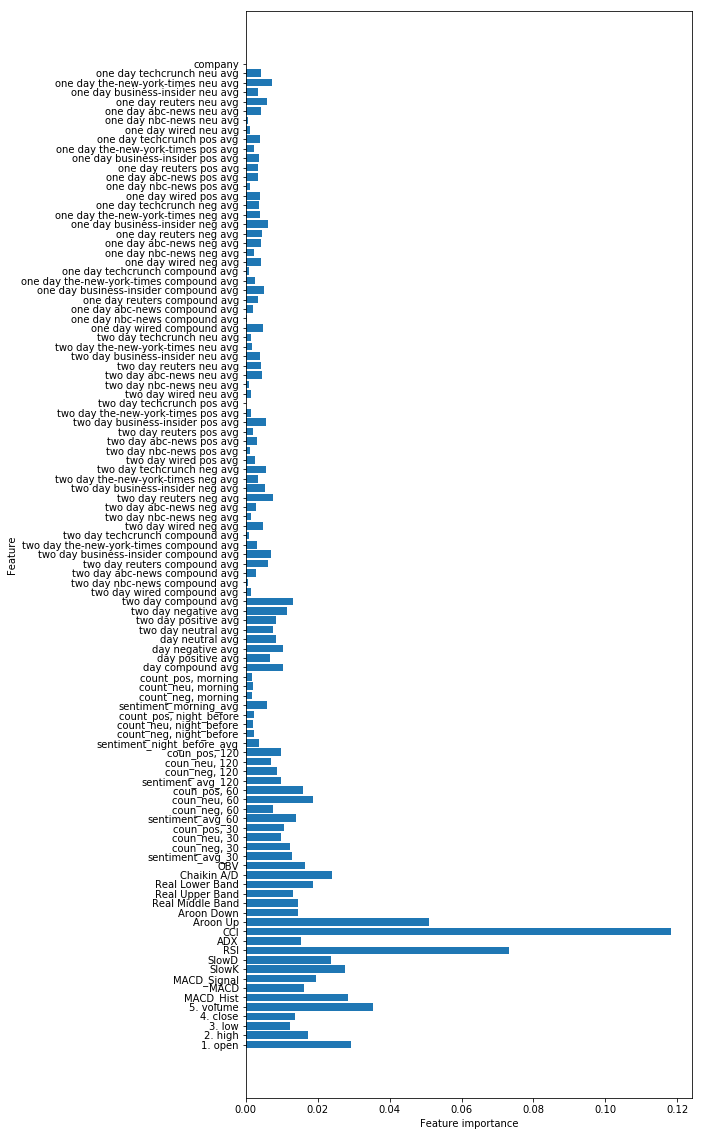

In [260]:
forest= RandomForestClassifier(n_estimators=100, max_depth= 30)
forest.fit(data_train, target_train)
forest.score(data_test,target_test)
feature_importances = forest.feature_importances_
feature_importance_list = [round(value, 4) for value in feature_importances]

def plot_feature_importances(model, data):
    n_features = data.shape[1]
    plt.figure(figsize=(8,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data.columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(forest, X)

feature_importance = dict(zip(X.columns, feature_importance_list))
print('Top 10 Features:')
sorted_dict = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for item in sorted_dict[:10]:
    print(item)

#### Gradient boost

train set score: 0.9919354838709677
test set score: 0.5714285714285714


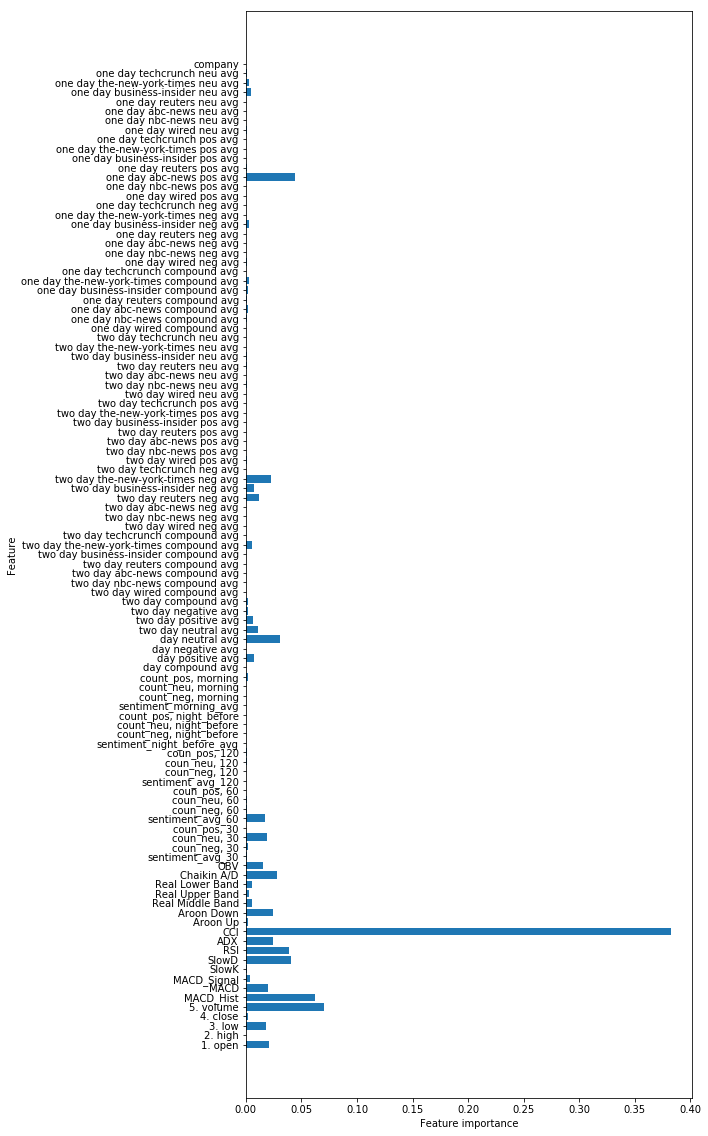

In [261]:
gradboost = GradientBoostingClassifier(random_state = 123, max_depth = 5, learning_rate = 0.01, n_estimators = 100)
gradboost.fit(data_train, target_train)
print('train set score: ' + str(gradboost.score(data_train, target_train)))
print('test set score: ' + str(gradboost.score(data_test, target_test)))

plot_feature_importances(gradboost, X)

#### Adaptive Boosting

Train Set Score: 100.00%
test set score: 61.90%


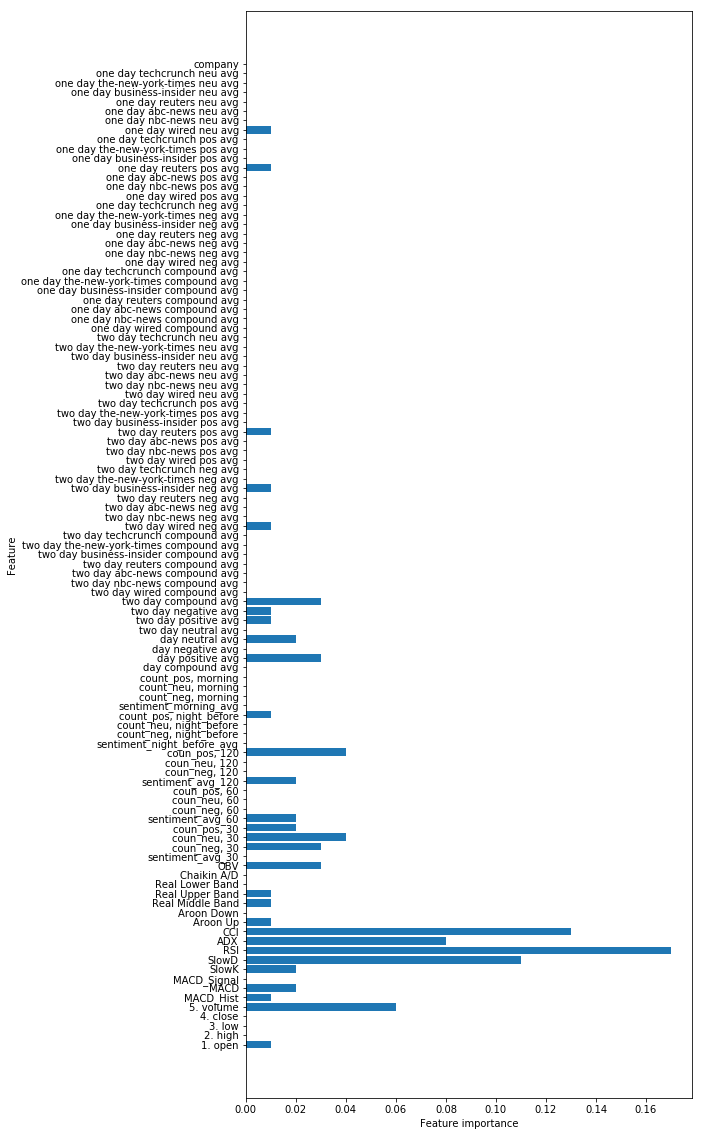

In [262]:
adaboost = AdaBoostClassifier(n_estimators=100)
adaboost.fit(data_train, target_train)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.005, n_estimators=100, random_state=None)
print('Train Set Score: {:0.2f}%'.format(adaboost.score(data_train, target_train) * 100))
print('test set score: {:0.2f}%'.format(adaboost.score(data_test, target_test)*100))
plot_feature_importances(adaboost, X)

#### Combinatoric Grid Searching

In [210]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

In [173]:
# Grid Search
ada_param_grid = {
    'learning_rate': [0.005, 0.01, 0.015],
    'n_estimators': [50, 100, 150],
}

In [206]:
dt_grid_search = GridSearchCV(adaboost, ada_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(X, target)

GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.005, 0.01, 0.015], 'n_estimators': [50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [212]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(scaled_df, target)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 76.52%
Mean Testing Score: 71.15%
Best Parameter Combination Found During Grid Search:


{'learning_rate': 0.005, 'n_estimators': 50}

#### Tweets 

In [245]:
X_tweets = X.loc[:,'sentiment_avg_30':'count_pos, morning']

In [252]:
data_train_tweets, data_test_tweets, target_train_tweets, target_test_tweets = train_test_split(X_tweets, target)

Train Set Score: 88.03%
test set score: 51.28%


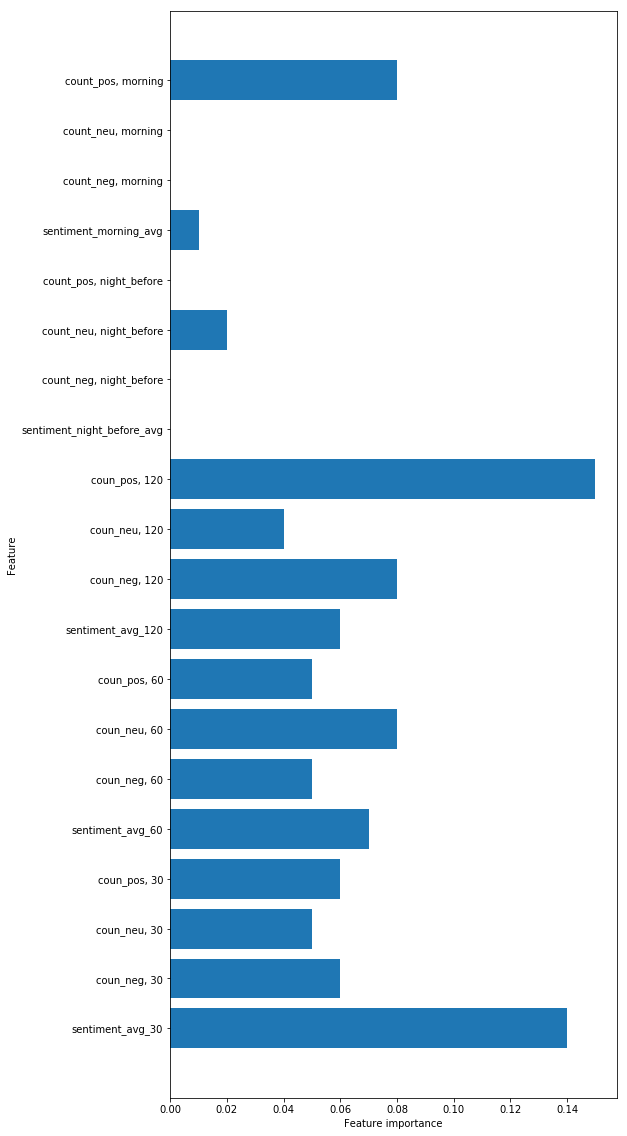

In [263]:
adaboost_tweets = AdaBoostClassifier(n_estimators=100)
adaboost_tweets.fit(data_train_tweets, target_train_tweets)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.005, n_estimators=100, random_state=None)
print('Train Set Score: {:0.2f}%'.format(adaboost_tweets.score(data_train_tweets, target_train_tweets) * 100))
print('test set score: {:0.2f}%'.format(adaboost_tweets.score(data_test_tweets, target_test_tweets)*100))
plot_feature_importances(adaboost_tweets, X_tweets)

In [283]:
tweeter_pos_count_two_hours = df['coun_pos, 120']

In [297]:
up_down = df.groupby(['coun_pos, 120'])['up_down'].count()

(array([52.,  1.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

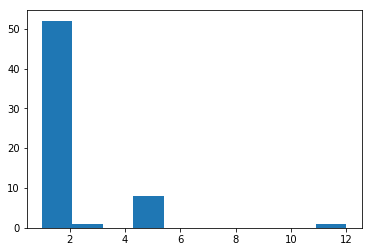

In [300]:
plt.hist(up_down)
# plt.bar(tweeter_pos_count_two_hours, (len(up_down) - sum(up_down)))

In [306]:
X_tweets_new = X_tweets
X_tweets_new["total_count_30"] = X_tweets_new['coun_neg, 30'] + X_tweets_new['coun_neu, 30'] + X_tweets_new['coun_pos, 30']
X_tweets_new["total_count_60"] = X_tweets_new['coun_neg, 60'] + X_tweets_new['coun_neu, 60'] + X_tweets_new['coun_pos, 60']
X_tweets_new["total_count_120"] = X_tweets_new['coun_neg, 120'] + X_tweets_new['coun_neu, 120'] + X_tweets_new['coun_pos, 120']
X_tweets_new["total_count_night_before"] = X_tweets_new['count_neg, night_before'] + X_tweets_new['count_neu, night_before'] + X_tweets_new['count_pos, night_before']
X_tweets_new["total_count_morning"] = X_tweets_new['count_neg, morning'] + X_tweets_new['count_neu, morning'] + X_tweets_new['count_pos, morning']

X_tweets_new = X_tweets_new.drop(['coun_neg, 30', 'coun_neu, 30', 'coun_pos, 30', 'coun_neg, 60', 'coun_neu, 60', 
                                  'coun_pos, 60', 'coun_neg, 120', 'coun_neu, 120', 'coun_pos, 120', 'count_neg, night_before', 
                                  'count_neu, night_before', 'count_pos, night_before','count_neg, morning','count_neu, morning', 'count_pos, morning'], axis =1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [318]:
X_tweets_new = X_tweets_new[['sentiment_avg_30', 'total_count_30', 'sentiment_avg_60','total_count_60', 'sentiment_avg_120', 'total_count_120', 'sentiment_night_before_avg', 'total_count_night_before', 'sentiment_morning_avg', 'total_count_morning']]

In [319]:
data_train_tweets_new, data_test_tweets_new, target_train_tweets_new, target_test_tweets_new = train_test_split(X_tweets_new, target)

Train Set Score: 86.32%
test set score: 69.23%


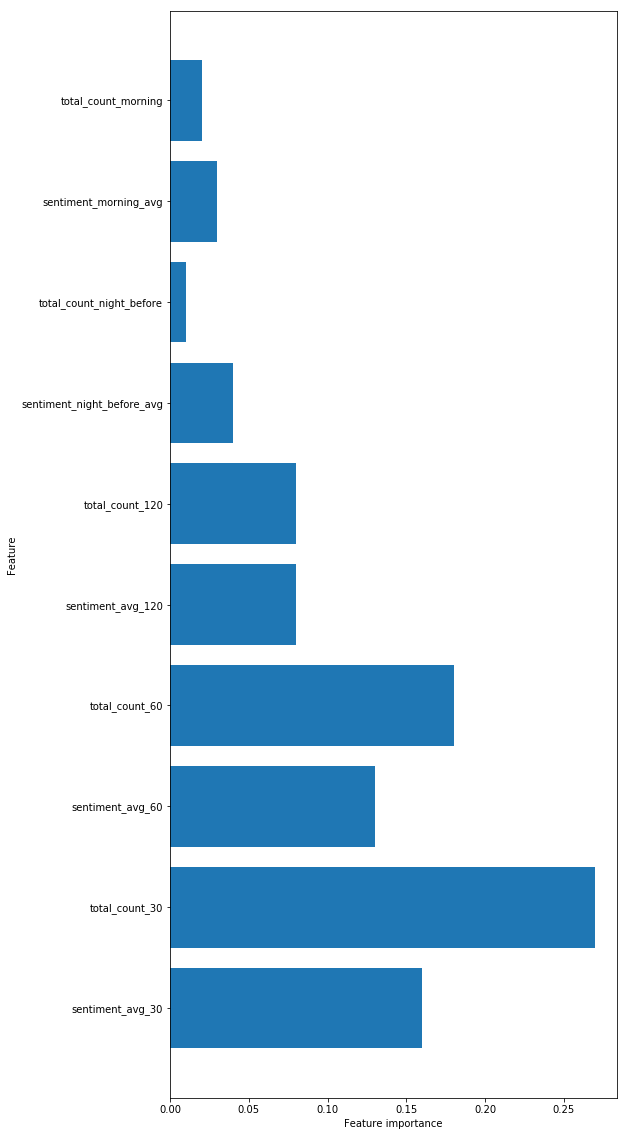

In [320]:
adaboost_tweets_new = AdaBoostClassifier(n_estimators=100)
adaboost_tweets_new.fit(data_train_tweets_new, target_train_tweets_new)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.005, n_estimators=100, random_state=None)
print('Train Set Score: {:0.2f}%'.format(adaboost_tweets_new.score(data_train_tweets_new, target_train_tweets_new) * 100))
print('test set score: {:0.2f}%'.format(adaboost_tweets_new.score(data_test_tweets_new, target_test_tweets_new)*100))
plot_feature_importances(adaboost_tweets_new, X_tweets_new)